In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math, re, time, random

from tqdm.notebook import tqdm
tqdm.pandas()

import os
os.chdir("I:")

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# os.chdir("C:\\Users\\Insight1\\Anaconda3")
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

C:\Users\Insight1\Anaconda3\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Preprocess and EDA

In [ ]:
age = pd.read_pickle('notes_with_age_and_impairment.pkl')
data = pd_read_pickle('')

In [ ]:
data['note_split'] = data['notes'].str.replace('\n', '').str.replace(r' +', ' ').str.split(' ') #replace \n with space or not
data['len_word'] = data['note_split'].apply(len)

print(df.shape)
df.drop(index = df[(df['len_word'] <=2) | (df['len_word']>= 2000)].index, inplace = True) # remonve empty or >2000 note
df.drop(index = df[df['le_months']>250].index, inplace = True) # remove life expect > 250 mo (21 years)
# above total removed 706 data
print(df.shape)

In [1]:
import string
from scipy import stats
def clean2(note):
    table = str.maketrans('', '','!"#$%&\'()*+,-./:;<=>?@‘¥£’—“[\\]^_`{|}~«»§é')
    s = note.translate(table)
    s1 = s.replace('\n',' ').lower()
    s2 = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', s1)
    st_clean = re.sub(r' +', ' ', s2)
    return st_clean

df['notes_clean'] = df['notes'].progress_apply(lambda x: clean2(x))
df['len_clean'] = df['notes_clean'].progress_apply(lambda x: len(x.split(' ')))
df[['key','notes','le_months','notes_clean','len_clean']].to_pickle('notes_clean.pkl')

df['noteclean_spacy_vec'] = df['notes_clean'].progress_apply(lambda x: nlp(x).vector)
df[['notes_clean','noteclean_spacy_vec','le_months']].to_pickle('clean_note_spacy_vec.pkl')

filt = (df['len_clean']<=2000) & (df['len_clean']>=100) & (df['le_months'] <=250)
df[filt]


df['note_spacy_vec'] = df['notes'].progress_apply(lambda x: nlp(x).vector)
df.to_pickle('spacy_vec.pkl') #save Spacy vectorized notes to pkl


df['le_months'] = df['le_months'].astype(int)
print(df.dtypes)

print(df['le_months'].astype(int).min())
print(df['le_months'].astype(int).max())

ave_mo = np.average(df['le_months'].to_numpy())
mode_mo = stats.mode(df['le_months'].to_numpy())
print('Months to live Average: {} \nMonths to live mode: {}'.format(ave_mo, mode_mo[0]))


OSError: [E050] Can't find model 'en_core_web_lg'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

### EDA graphs

### Word cloud

In [ ]:
df = pd.read_pickle('spacy_vec_split_len.pkl')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

filt = (df['len_word'] >= 500) & (df['len_word'] <= 600)
notewc = df.loc[filt, 'notes'].copy()
notewc.index = range(len(notewc))


filtwc = (df['len_lss'] >= 500) & (df['len_lss'] <= 600)
notewc = df.loc[filtwc, 'lss_note'].copy()
notewc.index = range(notewc.shape[0])

a = random.randrange(len(notewc))

STOPWORDS.update(['noted', 'was', 'say','Was','cited','Vv'])
# STOPWORDS.update(['noted', 'was', 'say','Was','cited','Vv','wa'])

stopwords = set(STOPWORDS)
wc = WordCloud(width = 800, height = 800, 
               background_color ='white', 
               stopwords = stopwords)
wc.generate(notewc[a])

# note = ' '.join(notewc[a][1]) 
# wc.generate(note)

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
wc.to_file('note_wc7.png')

# Feature Extraction

### Spacy

In [248]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def lemma_stem_stop(note):
    word_tokens = word_tokenize(note)
    
    # lemmatization
    lemma_words = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for w in word_tokens:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
        lemma_words.append(word3)

    # STOPWORDS
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", 
              "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", 
              "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", 
              "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    states = [x.lower() for x in states]
    
    stopwd = set(stopwords.words('english'))
    stopwd.update(['note', 'was', 'say','cite','vv','ii','iii','report', 'disclaim','disclaimer',
                   'request','underwrite','underwriter','life','expect','certify','take','company',
                  'id','written','write','ssn','social','security','number','llc']) 
    # add 'use'
    stopwd.update(states)
    filtered_sentence = [w for w in lemma_words if not w in stopwd] # can switch lemma or stem words
    
    #Stemming
    Stem_words = []
    ps =PorterStemmer()
    for w in filtered_sentence:
        rootWord=ps.stem(w)
        Stem_words.append(rootWord)
    
    lemma_stop_stem = Stem_words
    return lemma_stop_stem

In [ ]:
import spacy
nlp = spacy.load('en_core_web_lg')
df['spacy_lss'] = df['lss_note'].progress_apply(lambda x: nlp(' '.join(x[1])).vector)

df[['spacy_lss','len_lss','le_months']].to_pickle('spacy_lss.pkl')

df = pd.read_pickle('spacy_vec_split_len.pkl')


In [247]:
from string import digits

def remove_number(note):
    remove_digits = str.maketrans('', '', digits)
    no_num = note.translate(remove_digits)
    return no_num

remove_number(df['notes_clean'][0]) #should i remove numbers? eg A1c would be ac? try later


#df['len_char'] = df['notes'].apply(len)
df['note_split'] = df['notes'].str.replace('\n', '').str.replace(r' +', ' ').str.split(' ') #replace \n with space or not
df['len_word'] = df['note_split'].apply(len)

df.to_pickle('spacy_vec_split_len.pkl') #save Spacy vectorized notes to pkl


# df = pd.read_pickle('spacy_vec_split_len.pkl')
# type(df['note_split'][0])


df['note_spacy_vec'].apply(len)

'requesting company coventry  valley green rd fort washington pa   med rec from  to  kenneth wayne dulyea has history of diabetes with peripheral circulatory disorder hyperlipidemia cad htn ckd osa  tia  obesity and nqncqmpiaijpeysjrgeries included pci with stent of rca i   diabetes was documented as diet controlled glucose was  and alc   aflcwas  actos was prescribed  october bp was   afcin march was  actos was increased july bp was   january bp was   prostate biopsy in january was benign bp was  hctz was prescribed march glucbsewas  and alc  glucophage was increased  february glucose was  and ac   shortness of breath with vertigo was documented in february bp was  ekg showed normal sinus rhythm  with nonspecific inferior twave abnormalities unstable angina was reported in march pci with stent of rcawas done b secondary to total occlusion ekg showed sinus rhythm with some stt changes of nonspecific nature pyuria and hematuria were identified vp showed calcified mass on the floor of th

In [ ]:
# X and y from noteclean_spacy_vec
df = pd.read_pickle('clean_note_spacy_vec.pkl')
df2 = pd.read_pickle('notes_clean.pkl')
df['len_clean'] = df2['len_clean']

filt = df[(df['len_clean']>=100) & (df['len_clean']<=2000) & (df['le_months']<= 250)] # filter data for ML

X = np.array(filt['noteclean_spacy_vec'].values.tolist())
y = filt['le_months'].to_numpy()

In [ ]:
dfnn = data[(data['le_months'] <= 250) & (data['len_word'] <= 2000)]
X = np.array(dfnn['note_spacy_vec'].tolist())
# y = dfnn['le_months'].astype(np.float32).to_numpy()
y = dfnn['le_months']

In [3]:
df = pd.read_pickle('notes_clean.pkl')

In [249]:
df['lss_note'] = df['notes_clean'].progress_apply(lambda x: lemma_stem_stop(x))

In [252]:
df['len_lss'] = df['lss_note'].progress_apply(lambda x: len(x))

In [254]:
df['lss_corpus'] = df['lss_note'].progress_apply(lambda x: ' '.join(x))

In [90]:
os.chdir("I:")
df.to_pickle('lemma_stem_stop_filtered_note.pkl')

In [176]:
filt = (df['len_lss'] <=1000) & (df['len_lss'] >= 50) & (df['le_months']<=250 )
data = df[filt]

Text(0.5, 1.0, 'Number of Words per Note')

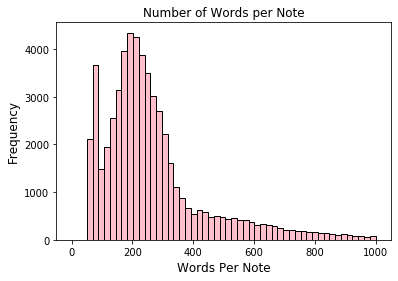

In [177]:
plt.hist(data['len_lss'].to_numpy(), bins = 50, color = 'pink', ec = 'black')
plt.xlabel('Words Per Note',fontsize =12)
plt.ylabel('Frequency',fontsize =12)
plt.xlim(-50,1050)
plt.title('Number of Words per Note')#### Plot life expectancy

In [ ]:
# X and y from noteclean_spacy_vec
filt = df[(df['len_clean']>=100) & (df['len_clean']<=2000) & (df['le_months']<= 250)] # filter data for ML

X = np.array(filt['noteclean_spacy_vec'].values.tolist())
y = filt['le_months'].to_numpy()


# X and y from note_spacy_vec
filt = df[(df['len_word']>3) & (df['len_word']<=2000) & (df['le_months']<= 250)] # filter data for ML
# filt['len_word'].value_counts().sort_index()

X = np.array(filt['note_spacy_vec'].values.tolist())
y = filt['le_months'].to_numpy()


# X and y from spacy_lss
df = pd.read_pickle('spacy_lss.pkl')
filt = df[(df['len_lss']>50) & (df['len_lss']<=1000) & (df['le_months']<= 250)] # filter data for ML
# filt['len_word'].value_counts().sort_index()

X = np.array(filt['spacy_lss'].values.tolist())
y = filt['le_months'].to_numpy()

### TF-IDF

In [295]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# transform len_lss
filt = (df['len_lss']>50) & (df['len_lss']<=1000) & (df['le_months']<= 250)  # filter data for ML
data = df[filt][['le_months','lss_note','lss_corpus']]

corpus = data['lss_corpus'].tolist()
vec = CountVectorizer()
bag_of_words = vec.fit_transform(corpus)
sum_words = bag_of_words.sum(axis=0) # sum word counts
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# return words_freq[:n]
vocab = [i[0] for i in words_freq[:4000]] # define vocabulary for tf-idf 4000 words

vectorizer = TfidfVectorizer(vocabulary=vocab)
corpus_tfidf = vectorizer.fit_transform(corpus)

X = corpus_tfidf.toarray()
y = data['le_months']

### LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0)
X = lda.fit_tranform(data)
y = 

# Model

In [352]:
from sklearn.model_selection import train_test_split
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
reg_lr = LinearRegression().fit(X_train, y_train)
y_pred_lr = reg_lr.predict(X_test)
print(reg_lr.score(X_test, y_test)) # R^2 variance weighted

### Xgboost

In [ ]:
#xgb regressor r2 score = 0.4118154583805178 for 57k data
#xgb reg spacy_lss r2= 0.44425965934761835  for 50-1000 len_lss, le_months<250

from xgboost import XGBRegressor
xgb = XGBRegressor().fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
print(r2_score(y_test, y_pred_xgb, multioutput='variance_weighted'))

### Bayesian

In [ ]:
# BayesianRidge regressor score = 0.4366820387501755, basically the model didn't work. 
# std for predicted label is nearly 60% of predicted value.
from sklearn import linear_model
reg_br = linear_model.BayesianRidge()
reg_br.fit(X_train, y_train)

print(reg_br.score(X_test, y_test))
print(reg_br.predict(X_test[:10], return_std = True))

###  Random Forest

In [ ]:
# random forest regressor score = 0.5402527642512915 for 57k data
# rf regressor r2 = 0.5560166555170266 when filted len_word<=750, le_months<=250
# rf regressor r2 = 0.5384426783146021 when filted 100<=len_word<=2000, le_months<=250 on noteclean_spacy_vec
#rf reg spacy_lss r2= 0.5800088178042535 for 50-1000 len_lss, le_months<250

from sklearn.ensemble import RandomForestRegressor 
reg_rf = RandomForestRegressor(n_estimators = 100, random_state = 0) 
reg_rf = RandomForestRegressor().fit(X_train, y_train)
y_test_rf = reg_rf.predict(X_test)
y_train_rf = reg_rf.predict(X_train)

print(reg_rf.score(X_train, y_train), reg_rf.score(X_test, y_test))
# r2 = 0.9483540267963761 0.6502525420270096 for n_estimator 100

### Bagging Regressor

In [ ]:
# random forest regressor score = 0.5402527642512915 for 57k data
# rf regressor r2 = 0.5560166555170266 when filted len_word<=750, le_months<=250
# rf regressor r2 = 0.5384426783146021 when filted 100<=len_word<=2000, le_months<=250 on noteclean_spacy_vec
#rf reg spacy_lss r2= 0.5800088178042535 for 50-1000 len_lss, le_months<250

from sklearn.ensemble import RandomForestRegressor 
reg_rf = RandomForestRegressor(n_estimators = 100, random_state = 0) 
reg_rf = RandomForestRegressor().fit(X_train, y_train)
y_test_rf = reg_rf.predict(X_test)
y_train_rf = reg_rf.predict(X_train)

print(reg_rf.score(X_train, y_train), reg_rf.score(X_test, y_test))
# r2 = 0.9483540267963761 0.6502525420270096 for n_estimator 100

### Voting Regressor

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
X = np.array([[1, 1], [2, 4], [3, 9], [4, 16], [5, 25], [6, 36]])
y = np.array([2, 6, 12, 20, 30, 42])
er = VotingRegressor([('lr', r1), ('rf', r2)])
print(er.fit(X, y).predict(X))

### Neural Network

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.models.Sequential()
model.add(keras.Input(shape=(300,)))
model.add(keras.layers.Dense(256, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(512, activation='relu', kernel_initializer = 'normal'))
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units = 1))
model.summary()

model.compile(optimizer= 'adam',loss = 'mean_squared_error')

checkpoint_filepath = '/log'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    batch_size=10000, epochs=3000, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)
print(model_log.history.keys())

model.load_weights(checkpoint_filepath)

y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred= model.predict(X_test)

from sklearn.metrics import mean_absolute_error
abs_er = mean_absolute_error(y_test, y_test_pred)
print(abs_er)

from sklearn.metrics import r2_score
rsq_train = r2_score(y_train, y_train_pred)
rsq_val = r2_score(y_val, y_val_pred)
rsq_test = r2_score(y_test, y_test_pred)

print(rsq_train, rsq_val, rsq_test)
# 100 epoches: abs_er= 19.991914022416207; rsq =0.6311475230416835; rsq_train = 0.9392278263642062 
# 20.781554059329675
# 0.6444936458044239 0.5632780303898981 0.5536371000303386

#3000 epoch (512/256/512) abs=23.203737412144314  r2 = 0.768495009799099  0.5852656900697112 0.5530109538595611
#3000 epoch (512/0.3,256/0.3, 512)abs=20.688904906315482 r2 =0.9325278290184188 0.6484640725710789 0.6103992408162731






dfnn['le_halfyear'] = dfnn['le_months'].apply(lambda x: round(x/6))

dfnn['le_halfyear'].value_counts().sort_index()

X = np.array(dfnn['note_spacy_vec'].tolist())
label = dfnn['le_halfyear']

X_trainval, X_test, label_trainval, label_test = train_test_split(X, label, test_size=0.2, random_state=42)
X_train, X_val, label_train, label_val = train_test_split(X_trainval, label_trainval, test_size=0.125, random_state=42)
# model.load_weights(checkpoint_filepath)

label_train_pred = np.argmax(model.predict(X_train),1)
label_val_pred = np.argmax(model.predict(X_val),1)
label_test_pred= np.argmax(model.predict(X_test),1)

from sklearn.metrics import accuracy_score
rsq_train = accuracy_score(label_train, label_train_pred)
rsq_val = accuracy_score(label_val, label_val_pred)
rsq_test = accuracy_score(label_test, label_test_pred)

print(rsq_train, rsq_val, rsq_test)
# 0.7535449361659181 0.2555634051571883 0.25633554083885207


# Utility

In [ ]:
def draw_hist(data, bins=50, color='gold', ec='black', xlabel='Month', ylabel='Frequency', title='title')
    plt.hist(data, bins=bins, color=color, ec=ec)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel,fontsize=12)
    plt.title(title)

In [ ]:
def draw_scatter(x, y, figsize=(8,8), label='Test', xlabel='True', y='Predicted', title='Random Forest Regressor')
    plt.figure(figsize=figsize)
    plt.scatter(x, y, label = label)
    plt.plot(range(300), range(300), '-k')
    plt.xlim(0, 300)
    plt.ylim(0, 300)
    plt.title(title)
    plt.xlabel(xlabel,fontsize =12)
    plt.ylabel(ylabel,fontsize =12)
    plt.legend()
    plt.show()
    # plt.grid(True)

In [ ]:
def draw_line(x, y):
    plt.plot(x)
    plt.plot(y)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

### LSTM

In [ ]:
class lstm(nn.Module):
    def __init__(self):
        super(lstm, self).__init__()
        self.lstm_layer = nn.LSTM(300, 300)
        self.linear_layer = nn.Linear(300, 1)
    def forward(self, input_vec):
        output, _ = self.lstm_layer(input_vec)
        logit = self.linear_layer(output.view(len(input_vec), -1))
        return logit
model = lstm()
print(model)

for p in model.named_parameters():
    print(p[0], str(tuple(p[1].size())))
    
model.to(device)
criterion = nn.L1Loss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

### Bert

In [ ]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [ ]:
def text_to_idmtx(note):
    ids = tokenizer.encode(note, add_special_tokens = False)
    idmtx = [[101]+ids[i:i+510]+[102] for i in range(0, len(ids), 510)]
    idmtx[-1] += (512-len(idmtx[-1]))*[0]
    idmtx = np.array(idmtx).reshape(-1, 512)
    return idmtx

df['len_token_id'] = df['token_id'].progress_apply(len)
df['token_id_matrix'] = df['notes'].progress_apply(text_to_idmtx)
# df[['key','notes', 'le_months', 'note_spacy_vec', 'bert_token_id','token_id_matrix']].to_csv('note_vec_token.csv', index = False)

df[['key','notes', 'le_months', 'note_spacy_vec','token_id_matrix']].to_pickle('note_vec_token.pkl')

In [ ]:
def k_row(mtx, k=6):
    row = mtx.shape[0]
    if row <= k:
        n = 512*(k-row)
        mtx_new = np.append(mtx.reshape(1, -1), [0]*n)
    else:
        mtx_new = np.squeeze(mtx.reshape(1,-1))[: k*512]
    return mtx_new



df['six_row'] = df['token_id_matrix'].progress_apply(k_row)
df['six_row'].apply(len).value_counts()

In [ ]:
dfbert = df[df['le_months'] <= 250]
X = np.array(dfbert['six_row'].tolist()).astype(np.int64)
y = dfbert['le_months'].astype(np.float32).to_numpy()

mask = (X!=0).astype(np.int8)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import datetime
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import  AutoTokenizer, AutoModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [ ]:
def dataLoader(input_ids, input_mask, labels, batch_size=32, val_test_size=0.1, random_seed=2020):
    """This function takes in all available data, split into train, val, test, and return a torch DataLoader for each. 
    """
    # split into train, validation, test 
    X_train_val, X_test, y_train_val, y_test = train_test_split(input_ids, labels, random_state=random_seed, test_size=val_test_size)
    mask_train_val, mask_test, _, _ = train_test_split(input_mask, labels, random_state=random_seed, test_size=val_test_size)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=random_seed, test_size=val_test_size)
    mask_train, mask_val, _, _ = train_test_split(mask_train_val, y_train_val, random_state=random_seed, test_size=val_test_size)

    # turn numpy array into tensor
    X_train, X_val, X_test  = torch.tensor(X_train), torch.tensor(X_val), torch.tensor(X_test)
    y_train, y_val, y_test = torch.tensor(y_train), torch.tensor(y_val), torch.tensor(y_test)
    mask_train, mask_val, mask_test = torch.tensor(mask_train), torch.tensor(mask_val), torch.tensor(mask_test)

    # Create the DataLoader for training set.
    train_data = TensorDataset(X_train, mask_train, y_train)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create the DataLoader for validation set.
    validation_data = TensorDataset(X_val, mask_val, y_val)
    validation_sampler = SequentialSampler(validation_data)
    validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    # Create the DataLoader for testing set.
    test_data = TensorDataset(X_test, mask_test, y_test)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    return(train_dataloader, validation_dataloader, test_dataloader)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
class Model(nn.Module):

    def __init__(self, num_class=1, freeze_bert = True):
        super(Model, self).__init__()

        #Instantiating clinical_bert model  
        self.clinical_bert_layer = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

        #Freeze bert layers
        if freeze_bert:
            for p in self.clinical_bert_layer.parameters():
                p.requires_grad = False

        self.lstm_layer = nn.LSTM(input_size=768, hidden_size=768, num_layers=1, batch_first=False)
        self.cls_layer = nn.Linear(768, num_class)

    def forward(self, input_ids, attention_mask):

        batch_size, lstm_length = input_ids.shape[0], int(input_ids.shape[1] / 512)
        input_ids, attention_mask = input_ids.view(-1, 512), attention_mask.view(-1, 512)
        last_hidden_state , _ = self.clinical_bert_layer(input_ids, attention_mask = attention_mask)
        cls_embedding = last_hidden_state[:, 0, :].unsqueeze(1)
        cls_embedding = cls_embedding.view(lstm_length, batch_size, -1)
        _, (hn, _) = self.lstm_layer(cls_embedding) 
        cls_holistic = hn[-1]
        logits = self.cls_layer(cls_holistic).squeeze()
        del input_ids, attention_mask, last_hidden_state, cls_embedding, hn, cls_holistic
        return logits


In [ ]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, config, scheduler=None):

    random.seed(config.random_seed)
    np.random.seed(config.random_seed)
    torch.manual_seed(config.random_seed)
    torch.cuda.manual_seed_all(config.random_seed)

      # ========================================
      #               Training
      # ========================================
    iterations = 0
    for epoch in tqdm(range(0, config.epochs)):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, config.epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0
    model.train()

    for step, batch in tqdm(enumerate(train_dataloader),desc='Training one epoch'):

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(config.device)
        b_input_mask = batch[1].to(config.device)
        b_targets = batch[2].to(config.device)

        model.zero_grad()  # set gradient to 0 before training
        logits = model(b_input_ids, attention_mask=b_input_mask)  # forward pass

        loss = criterion(logits, b_targets) # calculate the batch loss
        total_loss += loss.item() # accumulate loss in an epoch to compute average loss 

        elapsed = format_time(time.time() - t0) # Calculate elapsed time in minutes.
        if step % config.print_interval == 0 and not step == 0:
        print('  Batch {:>5,}  of  {:>5,}.  Elapsed: {:}.  Loss: {:>6.4f}.'.format(step, len(train_dataloader), elapsed, loss))

        loss.backward()  # back prop
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clip gradient to prevent exploding
        optimizer.step()  # update weights
        if scheduler:
        scheduler.step()  # Update the learning rate.
        iterations += 1

        # ========================================
        #               Validation
        # ========================================

        if iterations % config.val_interal == 0 and not iterations == 0:
        print("")
        print("Running Validation...")

        t1 = time.time()
        model.eval()   # Put the model in evaluation mode--the dropout layers behave differently during eval

        eval_loss, nb_eval_steps = 0, 0

        # Evaluate data for one epoch
        for batch in tqdm(val_dataloader, desc='Validation'):

            batch = tuple(t.to(config.device) for t in batch)       # Add batch to GPU
            b_input_ids, b_input_mask, b_targets = batch      # Unpack the inputs from our dataloader

            # Telling the model not to compute or store gradients, saving memory and speeding up validation
            with torch.no_grad():
                logits = model(b_input_ids, attention_mask=b_input_mask)

            loss = criterion(logits, b_targets) # calculate the batch loss
            eval_loss += loss

            nb_eval_steps += 1      # Track the number of batches

        # Report the final accuracy for this validation run.
        print("  MSE: {0:.4f}".format(eval_loss/nb_eval_steps))
        print("  Validation took: {:}".format(format_time(time.time() - t1)))

        torch.save({
            'epoch': epoch,
            'iterations': iterations,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss_MAE': eval_loss/nb_eval_steps,
            }, config.PATH + '_' + str(iterations))
        model.train()

    avg_train_loss = total_loss / len(train_dataloader)  # Calculate the average loss over the training data.      

    print("  Average training MSE: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
    print("")
    print("")

    print("")
    print("Training complete!")


In [ ]:
class Config():
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    batch_size=32
    epochs = 10
    val_interal=100   # do validation after this number of batches have been trained
    print_interval=40 # print the details of the training every this number of batch
    val_test_size=0.1  
    random_seed=42
    PATH = './checkpoints/checkpoint'

config = Config()

model = Model(num_class=1, freeze_bert=True)
model.to(config.device)

criterion = nn.L1Loss()
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )


# # dummy data
# input_ids = np.random.randint(1, 10000, (1000, 512))
# input_mask = np.ones_like(input_ids)
# targets = np.random.randint(1, 5, (1000,))

train_dataloader, val_dataloader, test_dataloader = dataLoader(X, mask, y)
total_steps = len(train_dataloader) * config.epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
config.batch_size = 8
config.val_interal = 500
config.epochs = 10

# model = Model(num_class=1, freeze_bert=True)
# model.to(config.device)
train(model, criterion, optimizer, train_dataloader, val_dataloader, config, scheduler)

In [ ]:
torch.cuda.empty_cache()
print(torch.cuda.max_memory_allocated(device=config.device) / 1024 / 1024 / 1024)
torch.cuda.memory_allocated(device=config.device) / 1024 / 1024 / 1024